**Macroscopic SIR approach with simple contagion dynamics**

We model the migration solving the ODEs, i.e. at a macroscopic level.

PROS: less computational extensive.
CONT: supposes that all nodes has the same probability to be infected at time t. It doesn't understand neighbours.

In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint
import sys
import os

project_root = '/mnt/c/Users/toniv/Documents/Github/Micro_and_Macro_SIRS_Modelling'
src_path = os.path.join(project_root, 'src')
sys.path.append(project_root)
sys.path.append(src_path)

In [3]:
# load the graph and the real data
G = nx.read_gml("../networks/migration_top_comm.gml")
timestamps = pd.read_csv("../data/sliced_user_timestamps.csv", index_col=0)

In [4]:
# slice the timestamps to the users of the Top Community
graph_nodes = set(G.nodes())
timestamps['user'] = timestamps['user'].astype(str)
filtered_timestamps = timestamps[timestamps['user'].isin(graph_nodes)]

# get the real infection evolution
date_counts = filtered_timestamps['day'].value_counts().sort_index()
I_real = date_counts.cumsum()

# get the initial infected: Early-infected + infected at day 0
initial_infected = filtered_timestamps[filtered_timestamps["day"] == 0]["user"].tolist()

**Initial parameters**

In [5]:
# Total population, N.
N = len(graph_nodes)

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = len(initial_infected), 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# A grid of time points (in days)
t = np.arange(0., 86.)

# Initial conditions vector
y0 = S0, I0, R0

**One run with arbitrary parameters**

In [6]:
from src.mf_simple import sir_model_ODE, sirs_model_ODE

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
params_sir = 0.5, 0.02
params_sirs = 0.5, 0.02, 0.02

# Solve SIR ODEs
ret_sir = odeint(sir_model_ODE, y0, t, args=(N, params_sir))
S_sir, I_sir, R_sir = ret_sir.T
R_0_sir = params_sir[0] / params_sir[1]

# Solve SIRS ODEs
ret_sirs = odeint(sirs_model_ODE, y0, t, args=(N, params_sirs))
S_sirs, I_sirs, R_sirs = ret_sirs.T
R_0_sirs = params_sirs[0] / params_sirs[1]

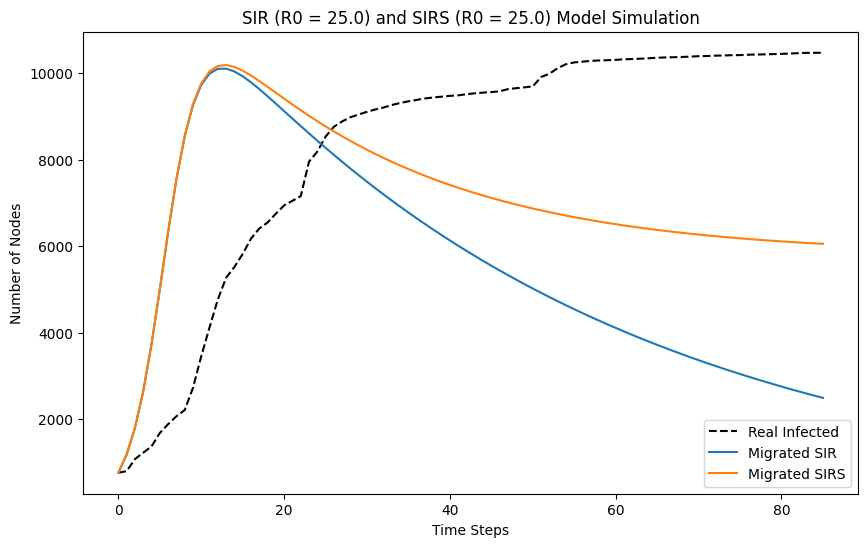

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(I_real.index, I_real.values, linestyle='--', color='black', label='Real Infected')
#plt.plot(S, label='Susceptible')
plt.plot(I_sir, label='Migrated SIR')
plt.plot(I_sirs, label='Migrated SIRS')
#plt.plot(R, label='Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title('SIR (R0 = '+str(R_0_sir)+') and SIRS (R0 = '+str(R_0_sirs)+') Model Simulation')
plt.legend()
plt.show()

**Fitting the model. Finding the best parameters (SIRS)**

Loss (MSE) at iteration with params [0.525 0.018 0.021]: 10795157.6913
Loss (MSE) at iteration with params [0.475 0.018 0.022]: 9854306.3111
Loss (MSE) at iteration with params [0.5   0.016 0.024]: 8759442.1942
Loss (MSE) at iteration with params [0.5   0.012 0.025]: 7362298.2748
Loss (MSE) at iteration with params [0.425 0.01  0.029]: 5680114.1937
Loss (MSE) at iteration with params [0.425 0.01  0.029]: 5680114.1937
Loss (MSE) at iteration with params [0.425 0.01  0.029]: 5680114.1937
Loss (MSE) at iteration with params [0.425 0.01  0.029]: 5680114.1937
Loss (MSE) at iteration with params [0.325      0.006      0.03333333]: 4100155.0875
Loss (MSE) at iteration with params [0.325      0.006      0.03333333]: 4100155.0875
Loss (MSE) at iteration with params [0.25       0.01377778 0.02955556]: 2764732.0779
Loss (MSE) at iteration with params [0.225      0.01059259 0.03107407]: 1419809.6342
Loss (MSE) at iteration with params [0.13333333 0.0091358  0.03541975]: 1212488.2990
Loss (MSE) at 

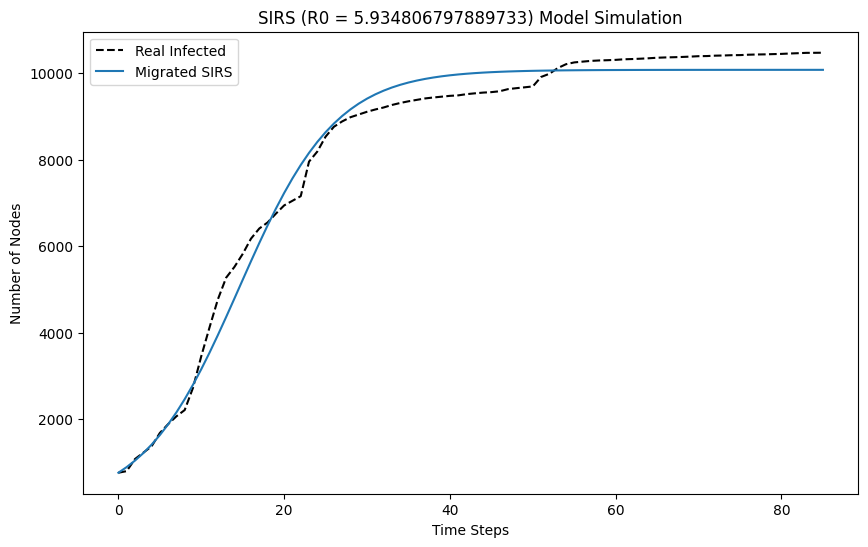

In [9]:
from src.mf_simple import sirs_model_ODE, loss_ODE

def callback(params):
    loss = loss_ODE(params, G, initial_infected, sirs_model_ODE, I_real)
    print(f'Loss (MSE) at iteration with params {params}: {loss:.4f}')

# Fit the model to our data
initial_params = [0.5, 0.02, 0.02]
result = minimize(loss_ODE, initial_params, args=(G, initial_infected, sirs_model_ODE, I_real), method='Nelder-Mead', callback = callback)

# Model SIRS with the best parameters
ret_sirs = odeint(sirs_model_ODE, y0, t, args=(N, result.x))
S_sirs, I_sirs, R_sirs = ret_sirs.T
R_0_sirs = result.x[0] / result.x[1]

plt.figure(figsize=(10, 6))
plt.plot(I_real.index, I_real.values, linestyle='--', color='black', label='Real Infected')
#plt.plot(S_sirs, label='Susceptible')
plt.plot(I_sirs, label='Migrated SIRS')
#plt.plot(R_sirs, label='Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title('SIRS (R0 = '+str(R_0_sirs)+') Model Simulation')
plt.legend()
plt.show()